In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress
import math
from datetime import datetime

#### Import Kestrel data and change year to 2015

In [2]:
dtypes=[datetime, float]
kes15 = pd.read_excel('Kestrel_data2015.xlsx',names=['time','ws'],header=3)
kes15['time']=kes15['time'].apply((lambda x: x.replace(year=2015)))


start_date = pd.Timestamp(2015,3,11,12,30,0)
end_date = pd.Timestamp(2015,3,11,13,5,0)
mask1 = (kes15['time'] > start_date) & (kes15['time'] <= end_date)
kes15_1 = kes15.loc[mask1]


start_date = pd.Timestamp(2015,3,11,13,10,0)
end_date = pd.Timestamp(2015,3,11,13,30,0)
mask2=(kes15['time'] > start_date) & (kes15['time'] <= end_date)
kes15_2 = kes15.loc[mask2]


#### Import 2015 Pitot data 

In [3]:
pit15_1 = pd.read_csv('WindTunnelCalibration2015_test1.csv',header=0)
pit15_1.columns = ['time','fan_rpm','air_temp','air_dens','press','ws']
pit15_1['time']=pit15_1['time'].apply((lambda x: pd.to_datetime(x[-5:])))
pit15_1['time']=pit15_1['time'].apply((lambda x: x.replace(year=2015)))
pit15_1['time']=pit15_1['time'].apply((lambda x: x.replace(month=3)))
pit15_1['time']=pit15_1['time'].apply((lambda x: x.replace(day=11)))

In [4]:
pit15_2=pd.read_csv('WindTunnelCalibration2015_test2.csv',header=0)
pit15_2.columns = ['time','fan_rpm','air_temp','air_dens','press','ws']
pit15_2['time']=pit15_2['time'].apply((lambda x: pd.to_datetime(x[-5:])))
pit15_2['time']=pit15_2['time'].apply((lambda x: x.replace(year=2015)))
pit15_2['time']=pit15_2['time'].apply((lambda x: x.replace(month=3)))
pit15_2['time']=pit15_2['time'].apply((lambda x: x.replace(day=11)))

#### Import 2015 Sonic data 

In [5]:
son15 = pd.read_csv('2015_sonic_1230_start.txt', sep=",", header=None)
son15.columns = ['gu','gv','gw','sound_speed','temp']
N=len(son15)
freq= 10   #Hz
dt= str(1/freq)+'S'   #seconds 
start_time=pd.Timestamp(2015,3,11,12,30,0.0)
time = pd.date_range(start = start_time,periods=N,freq=dt)
son15.insert(0,'time',time,True)
son15 = son15[son15.gu < 20]
son15 = son15[son15.gv < 20]

#### Uncomment to average

In [6]:
# son15_raw.index = pd.DatetimeIndex(son15_raw.time)
# avg_time = '10S'
# gu = (son15_raw['gu'].resample(avg_time).mean())
# gv = (son15_raw['gv'].resample(avg_time).mean())
# gw = (son15_raw['gw'].resample(avg_time).mean())
# sound_speed = (son15_raw['sound_speed'].resample(avg_time).mean())
# temp = (son15_raw['temp'].resample(avg_time).mean())

# data = {'gu':gu, 
#         'gv':gv,
#         'gw':gw,
#         'sound_speed':sound_speed,
#         'temp':temp} 
# son15=pd.DataFrame(data)
# son15.reset_index(drop=False, inplace=True)
# son15.head()

#### Convert Gill to Met

In [7]:
def convert_gill_to_met(gu,gv,gw):
    w = [x for x in gw]
    u = [-x for x in gv]
    v = [x for x in gu]
    
    return [u,v,w]


def find_alpha(u,v):
    dirs=[]
    for i in range(len(u)):
    
        if u[i] > 0:
            alpha = 90 - np.arctan(v[i]/u[i])+180
        elif u[i] < 0:
            alpha = 90 - np.arctan(v[i]/u[i])
        else:
            if v[i]>0:
                alpha = 0
            else:
                alpha = 180
            
        dirs.append(alpha)

    return dirs


def mean_horizontal_wind(u,v):
    mean_winds=[]
    for i in range(len(u)):
        M = np.sqrt((u[i])**2 + (v[i])**2)
        mean_winds.append(M)
    return mean_winds

In [8]:
met_dirs15 = convert_gill_to_met(son15['gu'],son15['gv'],son15['gw'])
u15=met_dirs15[0]
v15=met_dirs15[1]
w15=met_dirs15[2]
M15 = mean_horizontal_wind(u15,v15)
son15.insert(1,'u',u15,True)
son15.insert(2,'v',v15,True)
son15.insert(3,'w',w15,True)
son15.insert(4,'mean_wind',M15,True)
son15.head()

time     u     v     w  mean_wind    gu    gv    gw  \
0 2015-03-11 12:30:00.000  2.10 -0.08  0.01   2.101523 -0.08 -2.10  0.01   
1 2015-03-11 12:30:00.100  2.12 -0.09  0.01   2.121910 -0.09 -2.12  0.01   
2 2015-03-11 12:30:00.200  2.12 -0.10  0.01   2.122357 -0.10 -2.12  0.01   
3 2015-03-11 12:30:00.300  2.13 -0.12  0.01   2.133378 -0.12 -2.13  0.01   
4 2015-03-11 12:30:00.400  2.14 -0.14  0.01   2.144575 -0.14 -2.14  0.01   

   sound_speed   temp  
0       343.95  20.56  
1       343.95  20.56  
2       343.96  20.57  
3       343.96  20.57  
4       343.97  20.59

In [9]:
start_date = pd.Timestamp(2015,3,11,12,30,0)
end_date = pd.Timestamp(2015,3,11,13,5,0)
mask1 = (son15['time'] > start_date) & (son15['time'] <= end_date)
son15_1 = son15.loc[mask1]


start_date = pd.Timestamp(2015,3,11,13,10,0)
end_date = pd.Timestamp(2015,3,11,13,30,0)
mask2=(son15['time'] > start_date) & (son15['time'] <= end_date)
son15_2 = son15.loc[mask2]
son15_2.sort_values('mean_wind',ascending=False)
# son15_2 = son15_2.drop(25527)
# son15_2 = son15_2.drop(34739)

time      u      v      w  mean_wind     gu     gv  \
25527 2015-03-11 13:12:32.700 -14.24 -26.71  12.38  30.268824 -26.71  14.24   
34739 2015-03-11 13:27:53.900 -10.84 -26.47  10.04  28.603610 -26.47  10.84   
32877 2015-03-11 13:24:47.700   1.00 -20.57  -0.11  20.594293 -20.57  -1.00   
33378 2015-03-11 13:25:37.800   2.05 -20.09  -0.65  20.194321 -20.09  -2.05   
32965 2015-03-11 13:24:56.500  -0.23 -20.10   1.43  20.101316 -20.10   0.23   
33223 2015-03-11 13:25:22.300   2.41 -19.92  -1.19  20.065256 -19.92  -2.41   
32986 2015-03-11 13:24:58.600   2.24 -19.84  -0.46  19.966051 -19.84  -2.24   
33191 2015-03-11 13:25:19.100   0.68 -19.93  -0.75  19.941597 -19.93  -0.68   
32927 2015-03-11 13:24:52.700  -0.26 -19.85   1.65  19.851703 -19.85   0.26   
33526 2015-03-11 13:25:52.600   2.37 -19.67   0.19  19.812264 -19.67  -2.37   
32875 2015-03-11 13:24:47.500   1.90 -19.71  -0.57  19.801366 -19.71  -1.90   
33659 2015-03-11 13:26:05.900   1.76 -19.61  -0.59  19.688822 -19.61  -1.76   
32788 2015-03-11 13:24:38.800   1.89 -19.57  -0.36  19.661053 -19.57  -1.89   
33374 2015-03-11 13:25:37.400   0.20 -19.62   1.12  19.621019 -19.62  -0.20   
32789 2015-03-11 13:24:38.900   1.76 -19.51   0.53  19.589224 -19.51  -1.76   
33034 2015-03-11 13:25:03.400   1.84 -19.45  -0.24  19.536840 -19.45  -1.84   
33565 2015-03-11 13:25:56.500  -0.45 -19.51   0.64  19.515189 -19.51   0.45   
33550 2015-03-11 13:25:55.000   1.58 -19.36  -0.37  19.424366 -19.36  -1.58   
33149 2015-03-11 13:25:14.900  -0.30 -19.35   0.78  19.352325 -19.35   0.30   
33024 2015-03-11 13:25:02.400   1.57 -19.22   0.15  19.284017 -19.22  -1.57   
32746 2015-03-11 13:24:34.600  -1.07 -19.25   1.44  19.279715 -19.25   1.07   
33066 2015-03-11 13:25:06.600  -1.23 -19.20   1.14  19.239358 -19.20   1.23   
33545 2015-03-11 13:25:54.500   1.46 -19.11  -0.39  19.165691 -19.11  -1.46   
33098 2015-03-11 13:25:09.800   1.35 -18.99   0.58  19.037925 -18.99  -1.35   
33941 2015-03-11 13:26:34.100   0.43 -19.01  -0.87  19.014863 -19.01  -0.43   
33172 2015-03-11 13:25:17.200   0.96 -18.99  -0.89  19.014250 -18.99  -0.96   
33360 2015-03-11 13:25:36.000   0.71 -18.99   0.09  19.003268 -18.99  -0.71   
33118 2015-03-11 13:25:11.800   1.63 -18.92   0.21  18.990084 -18.92  -1.63   
32856 2015-03-11 13:24:45.600   0.10 -18.97   1.40  18.970264 -18.97  -0.10   
32900 2015-03-11 13:24:50.000   1.05 -18.93  -0.89  18.959098 -18.93  -1.05   
...                       ...    ...    ...    ...        ...    ...    ...   
35948 2015-03-11 13:29:54.800  -0.00  -0.38  -0.07   0.380000  -0.38   0.00   
35979 2015-03-11 13:29:57.900  -0.03  -0.37  -0.08   0.371214  -0.37   0.03   
35968 2015-03-11 13:29:56.800  -0.12  -0.35  -0.07   0.370000  -0.35   0.12   
35980 2015-03-11 13:29:58.000  -0.10  -0.35  -0.10   0.364005  -0.35   0.10   
35934 2015-03-11 13:29:53.400  -0.04  -0.36  -0.04   0.362215  -0.36   0.04   
35969 2015-03-11 13:29:56.900  -0.09  -0.35  -0.06   0.361386  -0.35   0.09   
35940 2015-03-11 13:29:54.000  -0.03  -0.36  -0.04   0.361248  -0.36   0.03   
35936 2015-03-11 13:29:53.600  -0.02  -0.36  -0.06   0.360555  -0.36   0.02   
35939 2015-03-11 13:29:53.900  -0.06  -0.35   0.00   0.355106  -0.35   0.06   
35972 2015-03-11 13:29:57.200  -0.13  -0.33  -0.01   0.354683  -0.33   0.13   
35931 2015-03-11 13:29:53.100   0.02  -0.35  -0.03   0.350571  -0.35  -0.02   
35935 2015-03-11 13:29:53.500  -0.00  -0.35  -0.03   0.350000  -0.35   0.00   
35938 2015-03-11 13:29:53.800   0.07  -0.34  -0.01   0.347131  -0.34  -0.07   
35978 2015-03-11 13:29:57.800  -0.02  -0.34  -0.07   0.340588  -0.34   0.02   
35981 2015-03-11 13:29:58.100  -0.13  -0.30  -0.09   0.326956  -0.30   0.13   
35982 2015-03-11 13:29:58.200  -0.14  -0.29  -0.08   0.322025  -0.29   0.14   
35937 2015-03-11 13:29:53.700   0.06  -0.31  -0.04   0.315753  -0.31  -0.06   
35987 2015-03-11 13:29:58.700  -0.21  -0.21  -0.11   0.296985  -0.21   0.21   
35985 2015-03-11 13:29:58.500  -0.16  -0.25  -0.12   0.296816  -0.25   0.16

#### Plot wind trace for test 1 2015

c:\users\pearl\miniconda3\envs\e350\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Text(0.5,1,'Wind Speed Traces Test 1 2015')

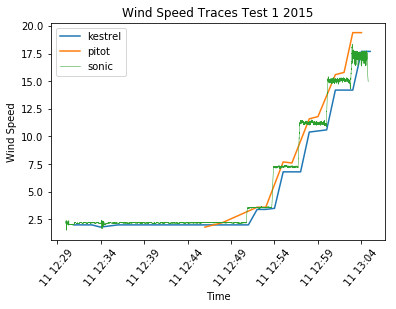

In [10]:
plt.plot(kes15_1['time'],kes15_1['ws'])
plt.plot(pit15_1['time'],pit15_1['ws'])
plt.plot(son15_1['time'],son15_1['mean_wind'],linewidth =0.51)
plt.legend(['kestrel','pitot','sonic'])
plt.xticks(rotation=50)
plt.ylabel('Wind Speed')
plt.xlabel('Time')
plt.title('Wind Speed Traces Test 1 2015')

Text(0.5,1,'Wind Speed Traces Test 2 2015')

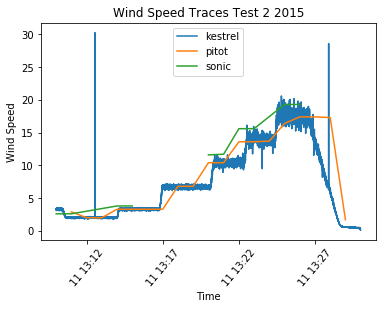

In [11]:
plt.plot(son15_2['time'],son15_2['mean_wind'])
plt.plot(kes15_2['time'],kes15_2['ws'])
plt.plot(pit15_2['time'],pit15_2['ws'])
plt.legend(['kestrel','pitot','sonic'])
plt.xticks(rotation=50)
plt.ylabel('Wind Speed')
plt.xlabel('Time')
plt.title('Wind Speed Traces Test 2 2015')

#### Import 2020 Kestrel data 

In [12]:
kes20 = pd.read_csv('kestrel_2020.csv',names=['time','ws'],header=0)
kes20['time'] = pd.to_datetime(kes20['time'])
# start_date = pd.Timestamp(2020,3,6,11,50,0)
# end_date = pd.Timestamp(2020,3,6,12,15,37)
# mask1 = (kes20['time'] > start_date) & (kes20['time'] <= end_date)
# kes20 = kes20.loc[mask1]


#### Import 2020 Sonic data 

In [13]:
son20 = pd.read_csv('sonic_2020.csv', header=None)
son20.columns = ['gu','gv','gw','sound_speed','temp']
N=len(son20)
freq= 10   #Hz
dt= str(1/freq)+'S'   #seconds 


start_time=pd.Timestamp(2020,3,6,11,49,0)
time = pd.date_range(start = start_time,periods=N,freq=dt)
son20.insert(0,'time',time,True)
met_dirs20 = convert_gill_to_met(son20['gu'],son20['gv'],son20['gw'])
u20=met_dirs20[0]
v20=met_dirs20[1]
w20=met_dirs20[2]
M20 = mean_horizontal_wind(u20,v20)

son20.insert(1,'u',u20,True)
son20.insert(2,'v',v20,True)
son20.insert(3,'w',w20,True)
son20.insert(4,'mean_wind',M20,True)

son20.sort_values('mean_wind',ascending=False).head()
son20 = son20.drop(13879)
son20 = son20.drop(15580)
son20 = son20.drop(3415)
son20 = son20.drop(14271)
son20 = son20.drop(9264)
son20 = son20.drop(12100)

start_date = pd.Timestamp(2020,3,6,11,49,0)
end_date = pd.Timestamp(2020,3,6,12,15,37)
mask2=(son20['time'] > start_date) & (son20['time'] <= end_date)
son20 = son20.loc[mask2]

#### Plot wind trace for test 2 2020

Text(0.5,1,'Wind Speed Traces Test 2 2020')

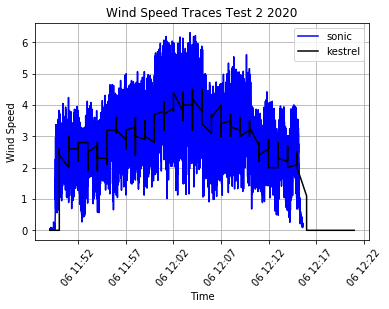

In [14]:
plt.plot(son20['time'],son20['mean_wind'],c='b')
plt.plot(kes20['time'],kes20['ws'],c='k')
plt.legend(['sonic','kestrel'])
plt.xticks(rotation=50)
plt.grid()
plt.ylabel('Wind Speed')
plt.xlabel('Time')
plt.title('Wind Speed Traces Test 2 2020')
